In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import torch
import torch.nn as nn

from models.fno2d import FNO2d
from gen_GRF import gaussian_random_field

In [2]:
# Plot defaults
# Set font default
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00',
                    '#000000']
matplotlib.rcParams['mathtext.rm'] = 'stix'
matplotlib.rcParams['mathtext.it'] = 'stix'
matplotlib.rcParams['mathtext.bf'] = 'stix'


matplotlib.rcParams["axes.formatter.limits"] = (-99, 99) #makes scientific notation threshold high
#plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
#plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' 'serif' 'Times
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r

# \usepackage{amsmath}
'''
'''

tickfontsize = 40
fontsize = 40
linewidth = 4
markersize = 15

SMALL_SIZE = tickfontsize
MEDIUM_SIZE = tickfontsize
BIGGER_SIZE = fontsize

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

shapes = ['o','s','^','D','*', 'x', 'P', 'h', 'v', '<', '>', 'X', 'd', 'p', '|', '_', '.', ',']


In [3]:
# get GRF data
def generate_GRF_data(s_vals=[0.5, 1.0, 1.5, 2.0],
                      sizes = [32, 64, 128, 256, 512],
                      sample_count = 5):
    '''
    Output is a dictionary which can be accessed via
    grf_data[s][size] --> tensor of shape [sample_count, 1, size, size]
    '''
    grf_data = {} # dicationary
    
    for s in s_vals:
        # generate all GRFs for this smoothness value
        grf_samples = {size: torch.zeros(sample_count,1,size,size) for size in sizes}
        for i in range(sample_count):
            # one sample at different resolutions
            one_sample = gaussian_random_field(s, sizes) 
            for id,size in enumerate(sizes):
                grf_samples[size][i,0,:,:] = one_sample[id]
        # collect
        grf_data[s] = grf_samples

    # add info
    grf_data['s_vals'] = s_vals
    grf_data['sizes'] = sizes
    grf_data['sample_count'] = sample_count
    
    return grf_data

grf_data = generate_GRF_data()
        


In [4]:
#from eval_model_helpers import *
import sys, os
sys.path.append(os.path.join('..'))
#from models.func_to_func2d_invasive import FNO2d

#from util.utilities_module import *
from gen_GRF import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [5]:
def weights_all_ones(model):
    sd = model.state_dict()
    for k in sd.keys():
        sd[k] = torch.ones_like(sd[k])
    model.load_state_dict(sd)
    return model

def weights_x10(model):
    sd = model.state_dict()
    for k in sd.keys():
        sd[k] = 10*sd[k]
    model.load_state_dict(sd)
    return model

In [6]:
# # check the discretization-inveriance visually
# modes = 16
# width = 32
# in_channels = 1
# out_channels = 1
# which_grid = 'xy'
# model = FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid)

# s = 1.0
# sizes = grf_data['sizes']
# for size in sizes[0:3]:
#     x = grf_data[s][size].view(-1,1,size,size)
#     pred = model(x).detach().squeeze()
#     plt.figure()
#     plt.imshow(pred[0])
#     plt.colorbar()
#     plt.show()
    

In [7]:
modes = 16
width = 32
in_channels = 1
out_channels = 1
which_grid = 'periodic'

# Initialize all random models
models = {}

# model with different initializations and GeLU activation
which_grid = None
models['normal'] = FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid)
models['normal_x10'] = weights_x10(
    FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid)
)
models['all_ones'] = weights_all_ones(
    FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid)
)

# model with ReLU activation
which_grid = None
models['normal_relu'] = FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid, act='relu')

# model with GeLU and xy grid
which_grid = 'xy'
models['normal_xygrid'] = FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid)

# model with GeLU and periodic grid
which_grid = 'periodic'
models['normal_periodic'] = FNO2d(modes,width,in_channels,out_channels,which_grid=which_grid)


In [8]:
################################################################
#
# 1d helpers
#
################################################################
def resize_rfft(ar, s):
    """
    Truncates or zero pads the highest frequencies of ``ar'' such that torch.fft.irfft(ar, n=s) is either an interpolation to a finer grid or a subsampling to a coarser grid.
    Args
        ar: (..., N) tensor, must satisfy real conjugate symmetry (not checked)
        s: (int), desired irfft output dimension >= 1
    Output
        out: (..., s//2 + 1) tensor
    """
    N = ar.shape[-1]
    # pdb.set_trace()
    s = s//2 + 1 if s >=1 else s//2
    if s >= N: # zero pad or leave alone
        out = torch.zeros(list(ar.shape[:-1]) + [s - N], dtype=torch.cfloat, device=ar.device)
        out = torch.cat((ar[..., :N], out), dim=-1)
    elif s >= 1: # truncate
        out = ar[..., :s]
    else: # edge case
        raise ValueError("s must be greater than or equal to 1.")

    return out


def resize_fft(ar, s):
    """
    Truncates or zero pads the highest frequencies of ``ar'' such that torch.fft.ifft(ar, n=s) is either an interpolation to a finer grid or a subsampling to a coarser grid.
    Reference: https://github.com/numpy/numpy/pull/7593
    Args
        ar: (..., N) tensor
        s: (int), desired ifft output dimension >= 1
    Output
        out: (..., s) tensor
    """
    N = ar.shape[-1]
    if s >= N: # zero pad or leave alone
        out = torch.zeros(list(ar.shape[:-1]) + [s - N], dtype=torch.cfloat, device=ar.device)
        out = torch.cat((ar[..., :N//2], out, ar[..., N//2:]), dim=-1)
    elif s >= 2: # truncate modes
        if s % 2: # odd
            out = torch.cat((ar[..., :s//2 + 1], ar[..., -s//2 + 1:]), dim=-1)
        else: # even
            out = torch.cat((ar[..., :s//2], ar[..., -s//2:]), dim=-1)
    else: # edge case s = 1
        if s < 1:
            raise ValueError("s must be greater than or equal to 1.")
        else:
            out = ar[..., 0:1]

    return out


def resize_rfft2(ar, size):
    """
    Truncates or zero pads the highest frequencies of ``ar'' such that torch.fft.irfft2(ar, s=s) is either an interpolation to a finer grid or a subsampling to a coarser grid.
    Args
        ar: (..., N_1, N_2) tensor, must satisfy real conjugate symmetry (not checked)
        s: (2) tuple, s=(s_1, s_2) desired irfft2 output dimension (s_i >=1)
    Output
        out: (..., s1, s_2//2 + 1) tensor
    """
    out = resize_rfft(ar, size) # last axis (rfft)
    return resize_fft(out.transpose(-2,-1), size).transpose(-2,-1) # second to last axis (fft)


def upsample(state, size):
    """
    Input: state (torch.Tensor)
           size (int)
           
    Zero pad the Fourier modes of state so that state has new resolution (size,size)
    """
    if size is not None and size != state.shape[-1]:
        state = torch.fft.irfft2(resize_rfft2(torch.fft.rfft2(state, norm="forward"), size), s=(size,size), norm="forward")
        
    return state
    

def downsample(state, size):
    '''
    state of shape (B,C,s,s) will be downsampled to
    size (B,C,size,size).

    Requires s / size to be an integer!
    '''
    s = state.shape[-1]
    ss = s//size
    state = state[...,::ss,::ss]

    assert state.shape[-1]==size, f'Downsampling failed; require that size divides state.shape[-1]. Found {size=}, {state.shape[-1]=}, {s/size=}'
    return state

def spatial_norm(x):
    '''
    x (torch.Tensor) of shape (B,C,size,size)
    Compute the L^2 norm of x over non-batch dimensions.
    '''
    return torch.sqrt( torch.square(x).mean(dim=[-3,-2,-1]) )

def dist_upsampled(x1,x2):
    size1,size2 = x1.shape[-1],x2.shape[-1]
    if size1<size2:
        x1 = upsample(x1,size2)
    elif size1>size2:
        x2 = upsample(x2,size1)
    return spatial_norm(x1-x2)

def dist_downsampled(x1,x2):
    size1,size2 = x1.shape[-1],x2.shape[-1]
    if size1<size2:
        x2 = downsample(x2,size1)
    elif size1>size2:
        x1 = downsample(x1,size2)
    return spatial_norm(x1-x2)

def layer_norms(states):
    '''
    states: list of length "n_layers", 
             states1[i] = hidden state at layer i, at fixed grid size
                          tensor of shape (B,C,size,size)
    '''
    batch, n_layers = states[0].shape[0], len(states)
    norms = torch.zeros(n_layers, batch)
    for i in range(n_layers):
        norms[i] = spatial_norm(states[i])
    return norms

def layer_distances_upsampled(states1,states2):
    batch, n_layers = states1[0].shape[0], len(states1)
    distances = torch.zeros(n_layers,batch)
    for i in range(n_layers):
        distances[i] = dist_upsampled(states1[i],states2[i])
    return distances

def layer_distances_downsampled(states1,states2):
    batch, n_layers = states1[0].shape[0], len(states1)
    distances = torch.zeros(n_layers,batch)
    for i in range(n_layers):
        distances[i] = dist_downsampled(states1[i],states2[i])
    return distances    
    

In [9]:
# def get_layer_outputs(model, samples):
#     '''
#     Input: model
#            samples: dictionary of tensor inputs with keys==sizes
#                     samples[size] of shape (B,C,size,size)
#     '''
#     sizes = samples.keys()

#     # get layer outputs for each size
#     layer_outputs = {}
#     for size in sizes:
#         x = samples[size]
#         x = x.view(-1,1,size,size)
#         layer_outputs[size] = model.layer_outputs(x)
        
#     return layer_outputs


# def convergence_study(model, samples):
#     #
#     sizes = samples.keys()
#     layer_outputs = get_layer_outputs(model, samples)
    
#     # 
#     size_ref = max(sizes)
#     layer_ref = layer_outputs.pop(size_ref)
#     n_layers = len(layer_ref)
#     print('Reference grid size (treated as ground truth): ',size_ref)

#     # number of samples
#     samp_count = layer_ref[0].shape[0]

#     # compute norms and errors
#     norm_ref = layer_norms(layer_ref).unsqueeze(0) # shape (1, n_layer, samp_count)
#     err_upsample = torch.zeros(len(sizes)-1,n_layers, samp_count) # shape (len(sizes), n_layer, samp_count)
#     err_downsample =  torch.zeros(len(sizes)-1,n_layers, samp_count) # shape (len(sizes), n_layer, samp_count)

#     #
#     for j,size in enumerate(sizes):
#         if size==size_ref:
#             continue

#         this_layer = layer_outputs[size]
#         err_upsample[j] = layer_distances_upsampled( this_layer, layer_ref )
#         err_downsample[j] = layer_distances_downsampled( this_layer, layer_ref )

#     return norm_ref, err_upsample, err_downsample



In [10]:
def discretization_errors(model, x, size_min=32):
    '''
    Given model and input x (shape: (B,C,size,size)), 
    will compute discretization errors and convergence rates
    across layers.

    x is subsampled with minimal grid size given by size_min.
    Note: size should be a power of 2.
    '''
    # determine subsampling range
    ss_max = x.shape[-1] // size_min # maximal subsampling rate
    exponent_max = ss_max.bit_length() # ss_max = 2**(exponent_max-1)
    ss_range = [2**exponent for exponent in range(1,exponent_max)]
    sizes = [x.shape[-1] // ss for ss in ss_range]

    # compute norms and errors
    # ... reference discretization
    samp_count = x.shape[0]
    layers_ref = model.layer_outputs(x)
    norm_ref = layer_norms(layers_ref).unsqueeze(0) # shape (1, n_layer, samp_count)

    # ... compute errors from coarser discretizations
    n_layers = len(layers_ref)
    err_upsample   = torch.zeros(len(ss_range),n_layers, samp_count)
    err_downsample = torch.zeros(len(ss_range),n_layers, samp_count)

    for j,ss in enumerate(ss_range):
        x_ss = x[...,::ss,::ss] # subsampled input
        layers_ss = model.layer_outputs(x_ss)
        #
        err_upsample[j]   = layer_distances_upsampled( layers_ss, layers_ref )
        err_downsample[j] = layer_distances_downsampled( layers_ss, layers_ref )

    # switch to numpy
    norm_ref = norm_ref.cpu().numpy()
    err_upsample = err_upsample.cpu().numpy()
    err_downsample = err_downsample.cpu().numpy()
    
    # normalize and output mean / std
    err_up = err_upsample / norm_ref
    err_down = err_downsample / norm_ref
    
    err_up_mean = np.mean(err_up, axis=-1)
    err_up_std = 2*np.std(err_up, axis=-1)
    
    err_down_mean = np.mean(err_down, axis=-1)
    err_down_std = 2*np.std(err_down, axis=-1)

    # re-package this
    errors_upsample = {
        'mean': err_up_mean,
        'std': err_up_std
    }
    errors_downsample = {
        'mean': err_down_mean,
        'std': err_down_std
    }
    
    return sizes, norm_ref, errors_upsample, errors_downsample


In [11]:
def plot_discretization_errors(sizes, norm_ref, errors, ax=None, title='', outfile=None):
    show_plot = False
    if ax==None:
        # create a new figure
        fig, ax = plt.subplots(1,1, figsize=(10, 10))
        show_plot = True

    #
    slopes = []
    
    for layer in range(norm_ref.shape[1]):
        ax.plot(sizes, errors['mean'][:,layer], 
                 label = f'Layer {layer+1}',
                 color = CB_color_cycle[layer],
                 marker = shapes[layer],
                 linewidth = linewidth,
                 markersize = markersize)
        ax.errorbar(sizes, errors['mean'][:,layer], yerr=errors['std'][:,layer],
                     color = CB_color_cycle[layer])
        ax.fill_between(sizes, 
                        errors['mean'][:,layer] - errors['std'][:,layer],  # lower bound
                        errors['mean'][:,layer] + errors['std'][:,layer],  # upper bound
                        alpha=0.2, color = CB_color_cycle[layer])
        p = np.polyfit(np.log(sizes), np.log(errors['mean'][:,layer]), 1)
        slopes.append(p[0])

    #
    if len(title)>0:
        # add space
        title = title + ',   '
    ax.set_title(title + f'Average Slope = {np.mean(slopes):.2f}') 
    # logscale
    ax.set_yscale('log')
    # set y range
    ax.set_ylim([np.min(errors['mean'])/2, np.max(errors['mean'])*2])
    ax.set_xscale('log') 
    ax.set_xlabel('N')
    ax.set_xticks([])
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.grid()   
    
    # no scientific notation x labels
    ax.set_xticks(sizes, sizes)
    
    if outfile!=None:
        plt.savefig(outfile)
    if show_plot:
        ax.set_ylabel('Relative Error')
        plt.show()

In [16]:
def plot_discret_errors_vs_s(model, grf_data, outfile=None):
    discret_errors_up = {}
    discret_errors_down = {}

    for s in grf_data['s_vals']:
        x = grf_data[s][512]
        sizes, norm_ref, errors_upsample, errors_downsample = discretization_errors(model, x)
        #
        discret_errors_up[s] = (sizes, norm_ref, errors_upsample)
        discret_errors_down[s] = (sizes, norm_ref, errors_downsample)

    # plot upsampled errors
    fix, ax = plt.subplots(1,4, figsize=(40, 10))
    for j,s in enumerate(grf_data['s_vals']):
        title = f's = {s}'
        plot_discretization_errors(*discret_errors_up[s],ax=ax[j],title=title)
    # put legend on right of all subplots
    ax[0].set_ylabel('Relative Error')
    ax[-1].legend(bbox_to_anchor=(1, 0.8))
    if outfile!=None:
        # save figure
        plt.savefig('upsampled_' + outfile)
    plt.show()

    # plot downsampled errors
    fix, ax = plt.subplots(1,4, figsize=(40, 10))
    for j,s in enumerate(grf_data['s_vals']):
        title = f's = {s}'
        plot_discretization_errors(*discret_errors_down[s],ax=ax[j],title=title)
    # put legend on right of all subplots
    ax[0].set_ylabel('Relative Error')
    ax[-1].legend(bbox_to_anchor=(1, 0.8))
    if outfile!=None:
        # save figure
        plt.savefig('downsampled_' + outfile)
    plt.show()

normal


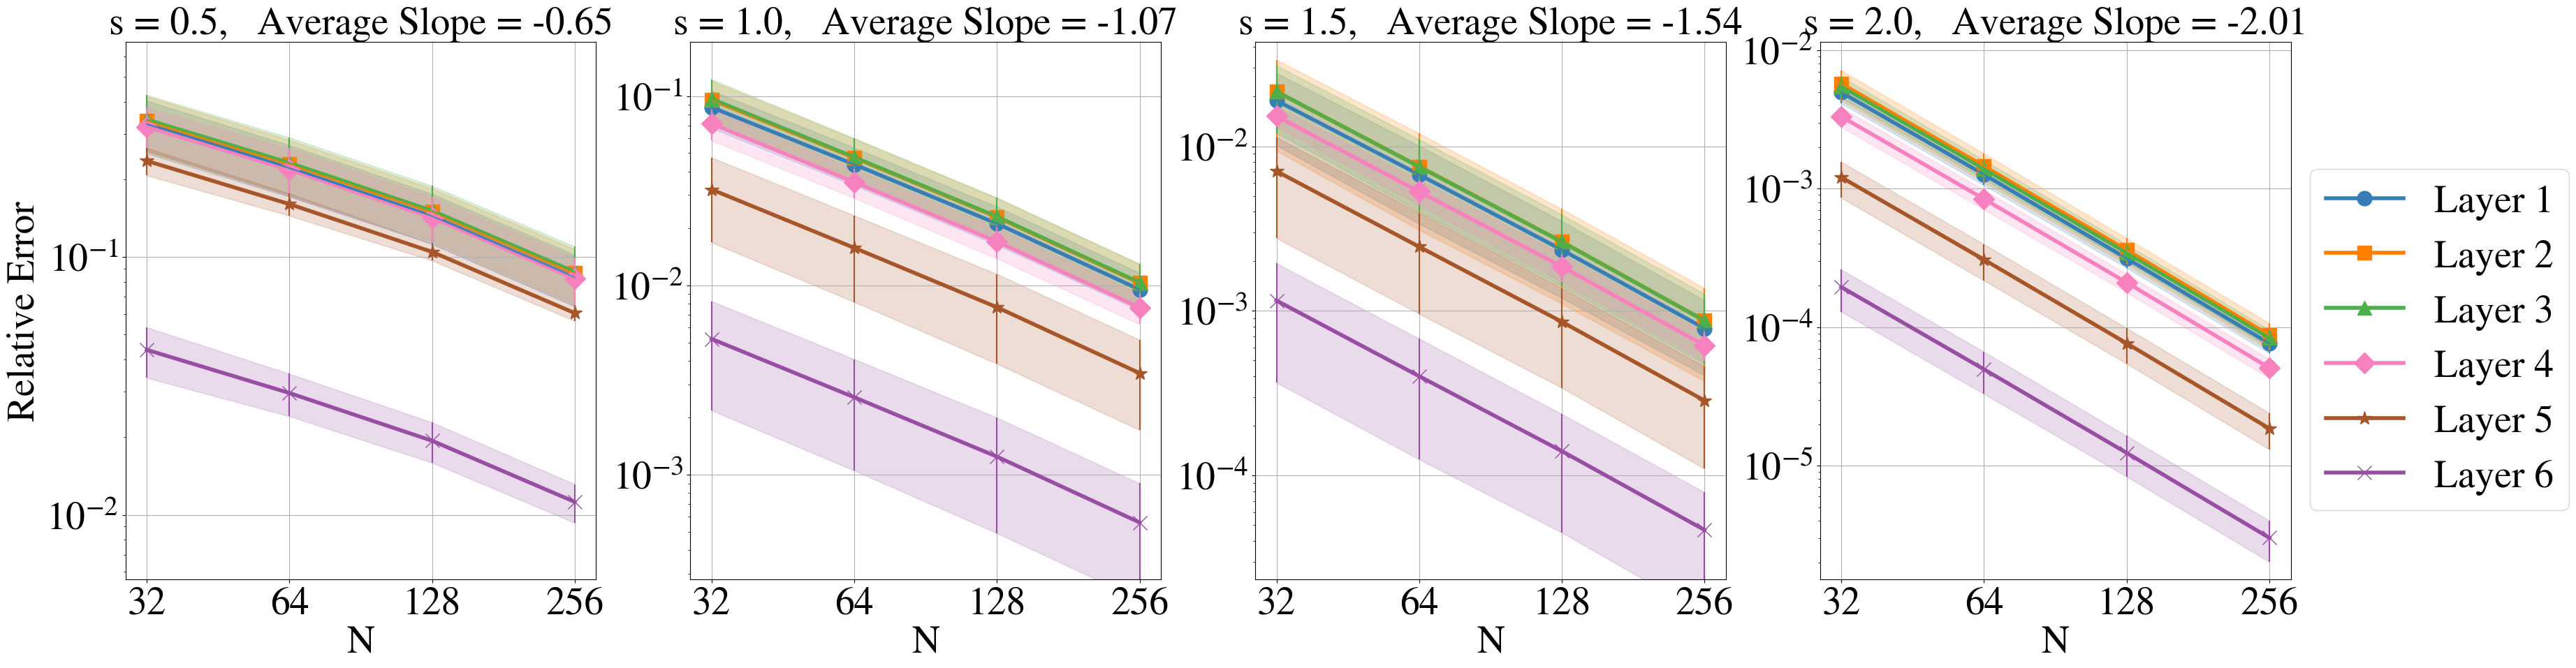

/tmp/ipykernel_24696/3665316363.py:24: RuntimeWarning: divide by zero encountered in log
  p = np.polyfit(np.log(sizes), np.log(errors['mean'][:,layer]), 1)
/tmp/ipykernel_24696/3665316363.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([np.min(errors['mean'])/2, np.max(errors['mean'])*2])


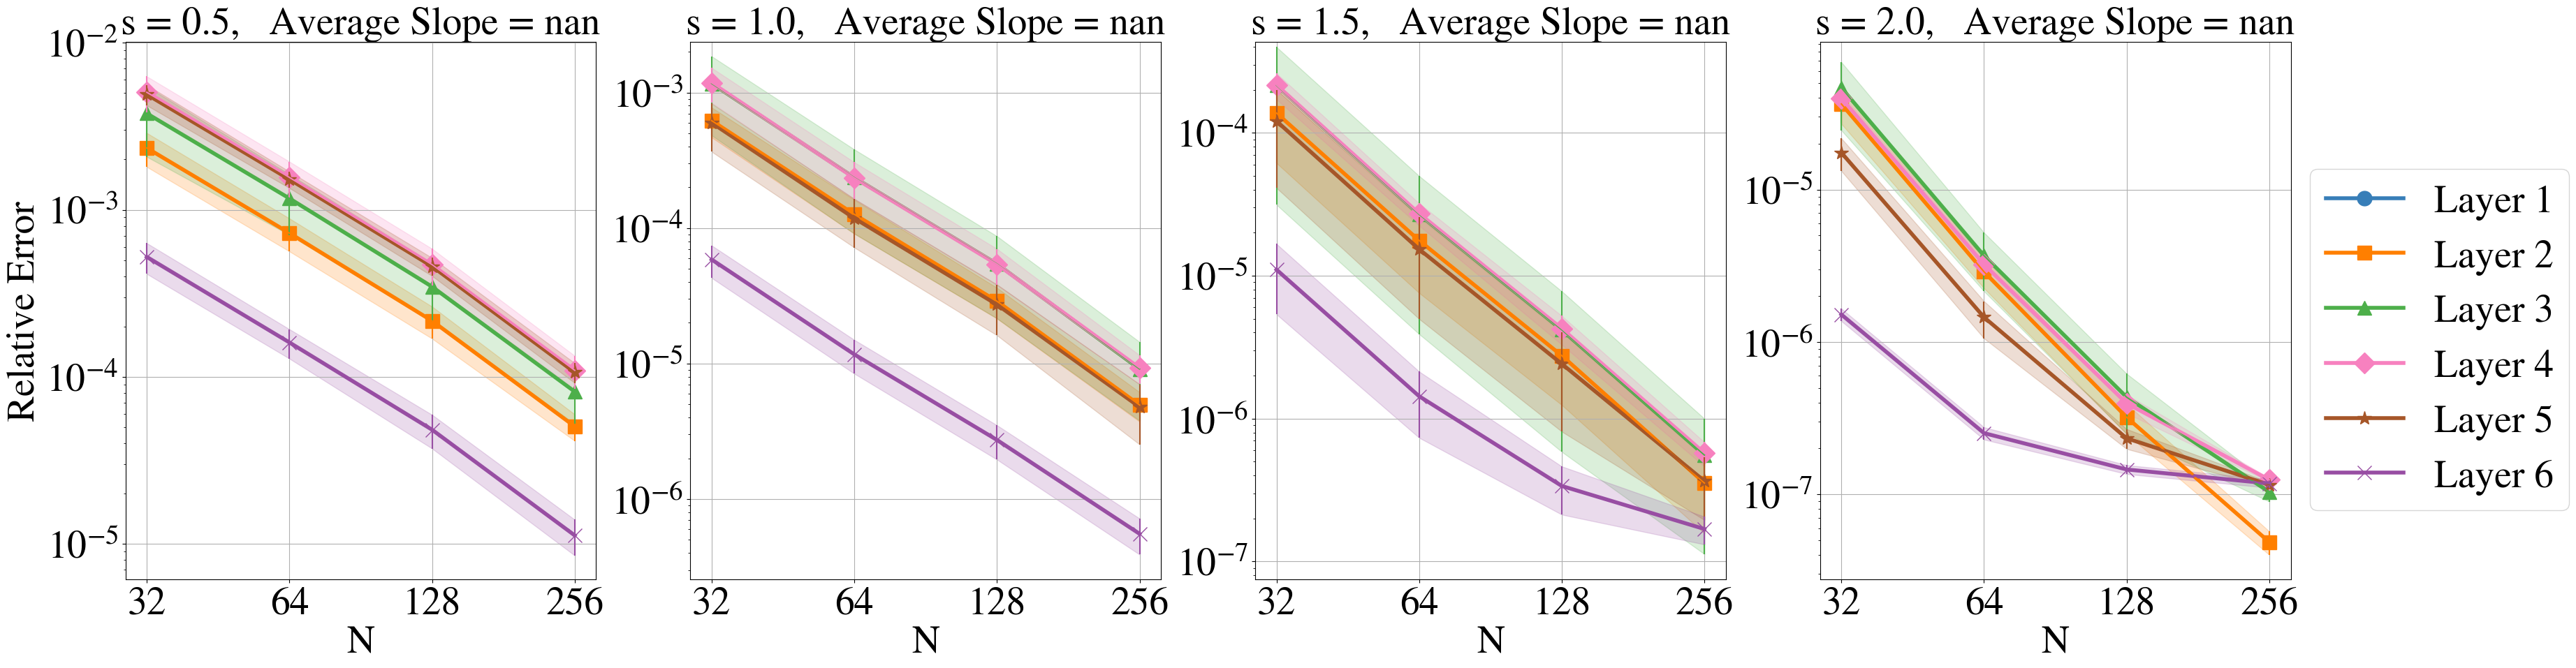

normal_x10


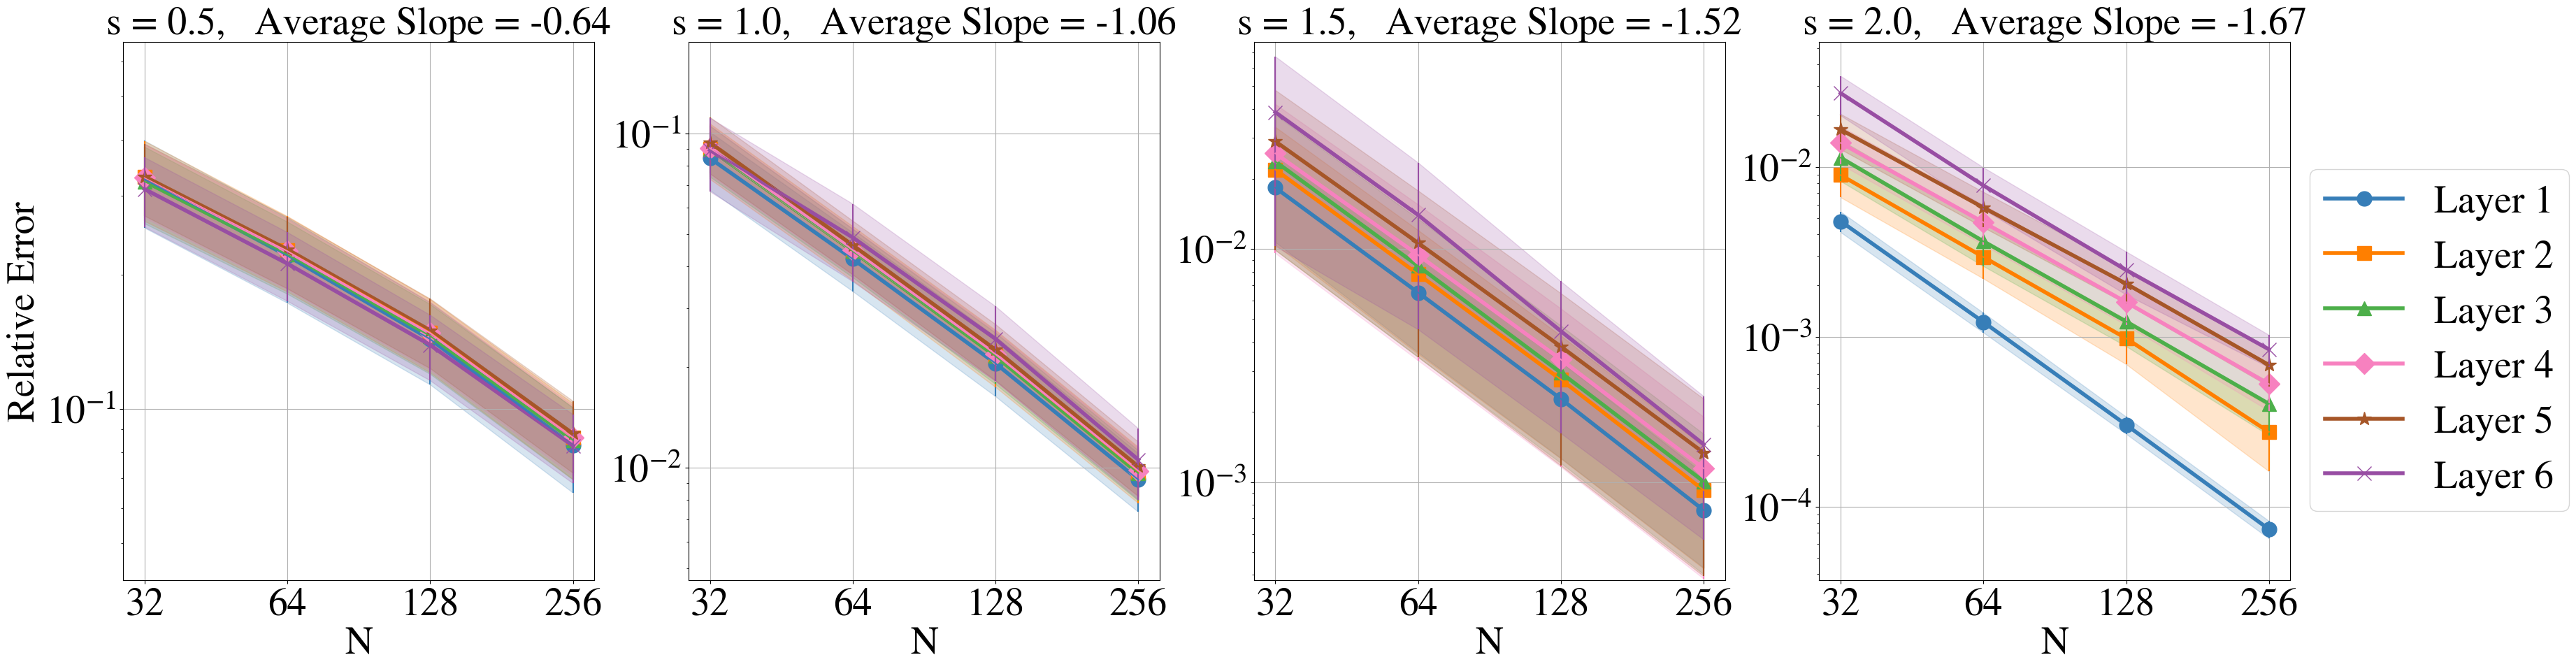

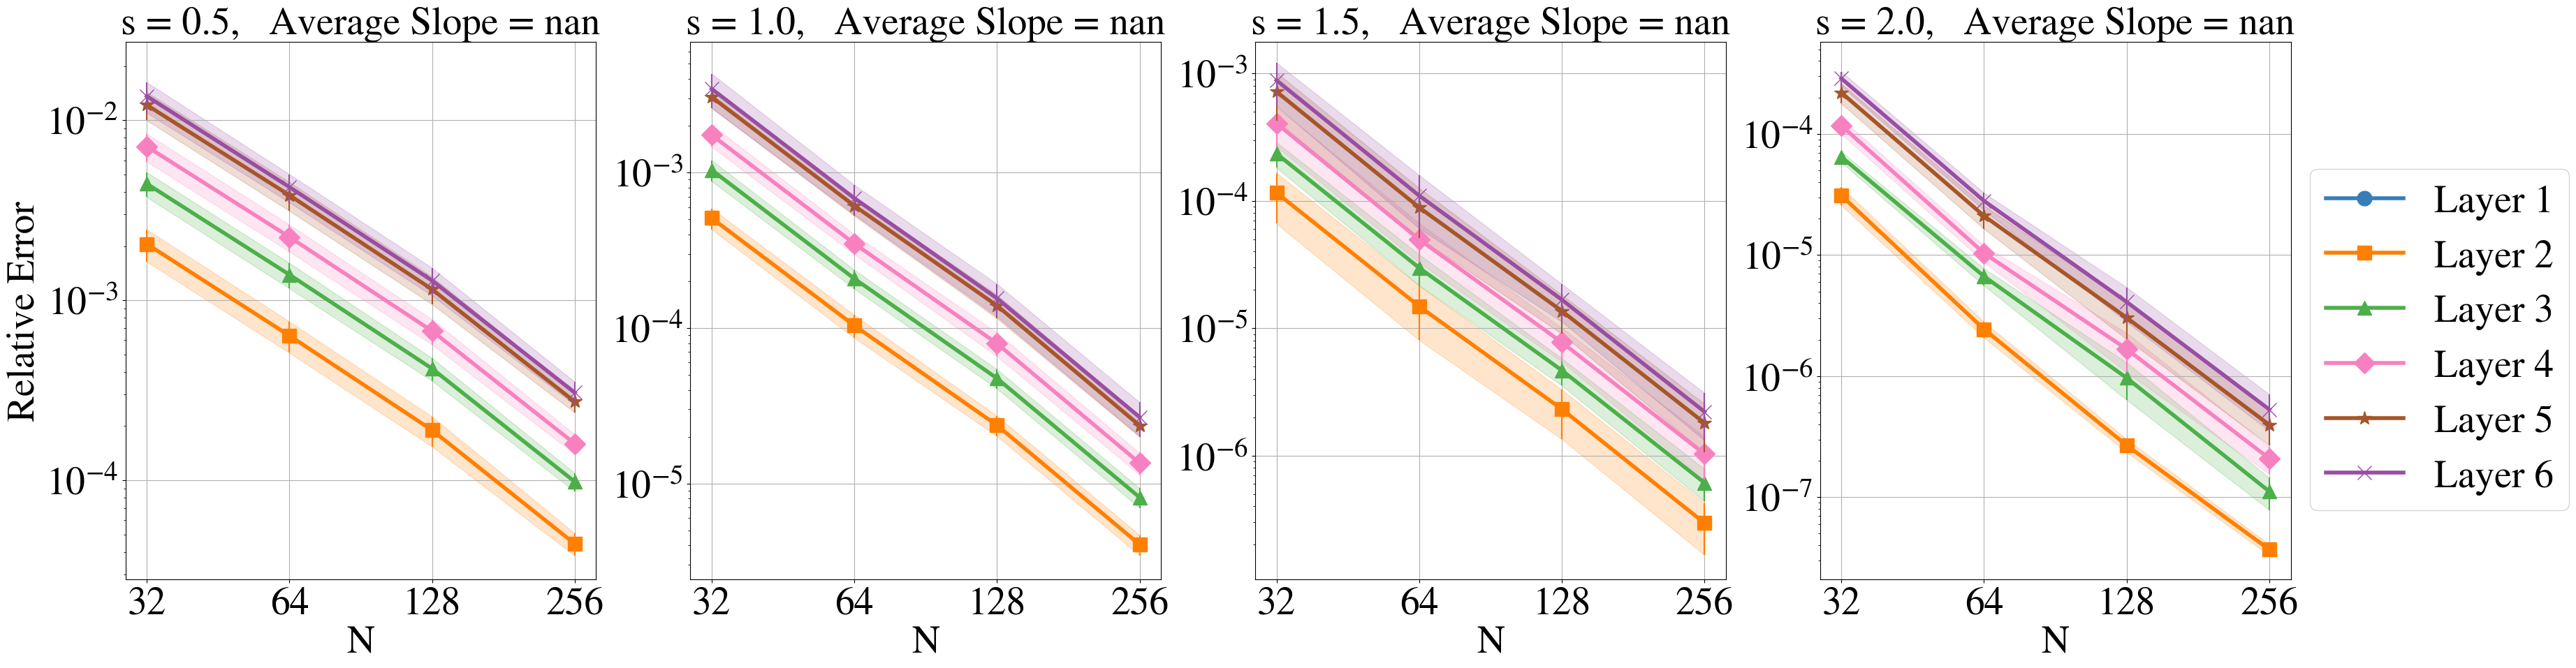

all_ones


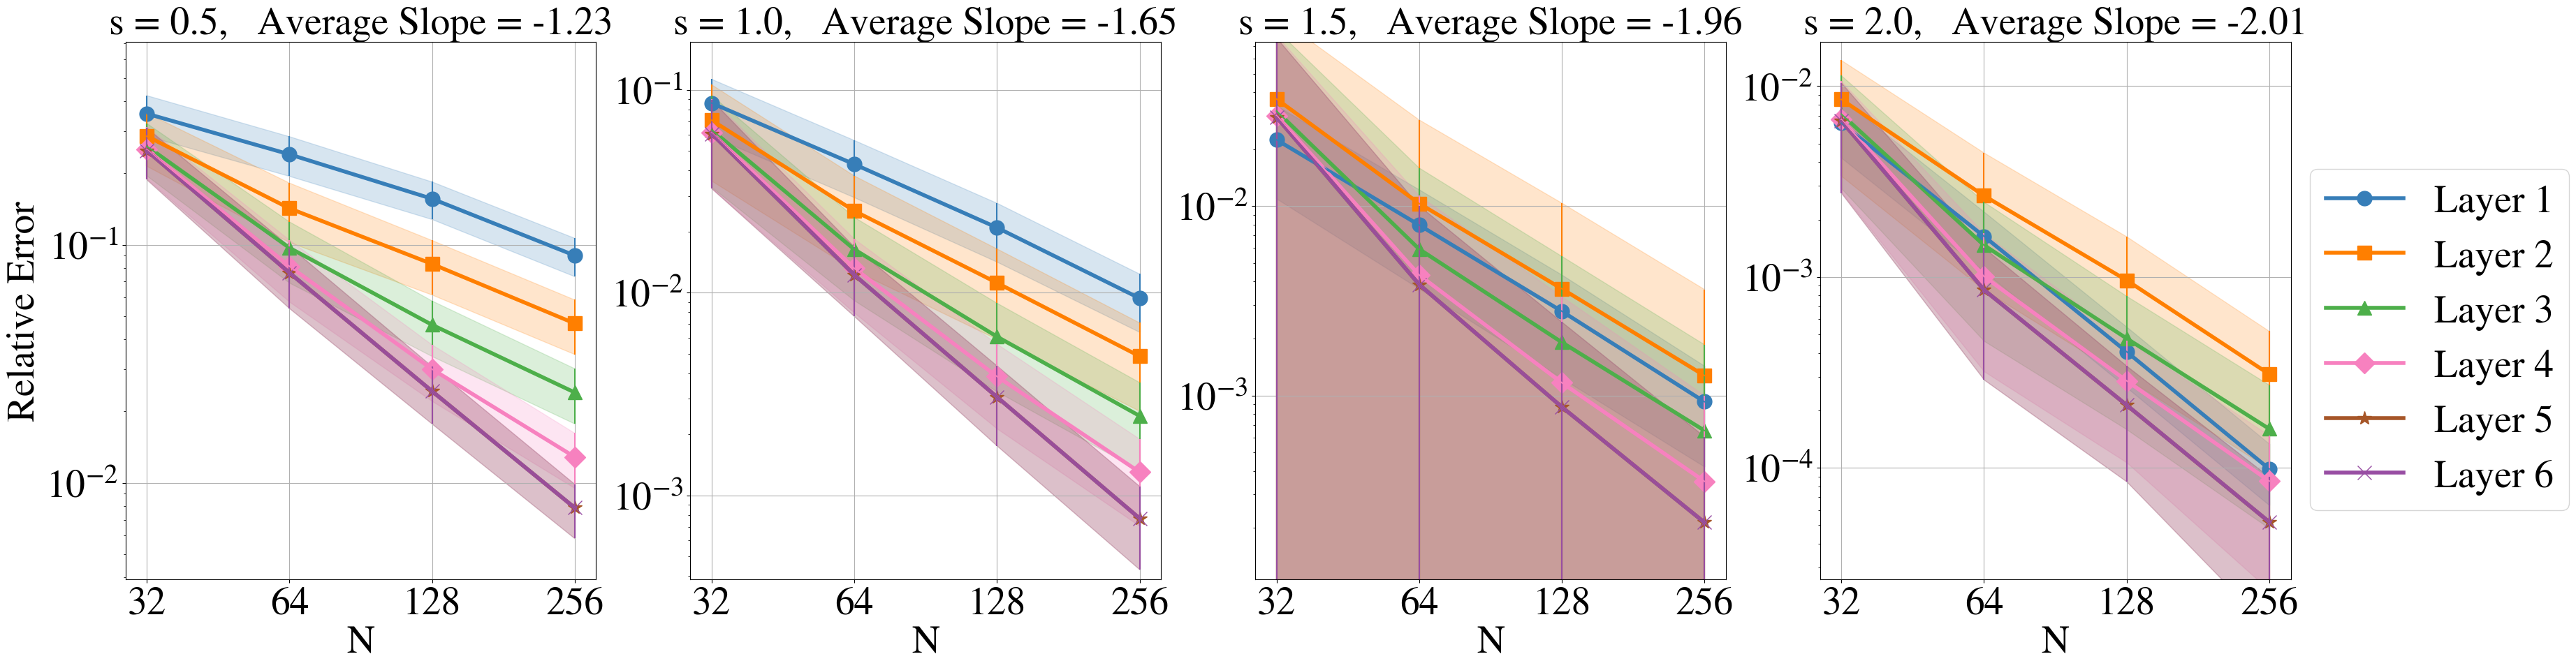

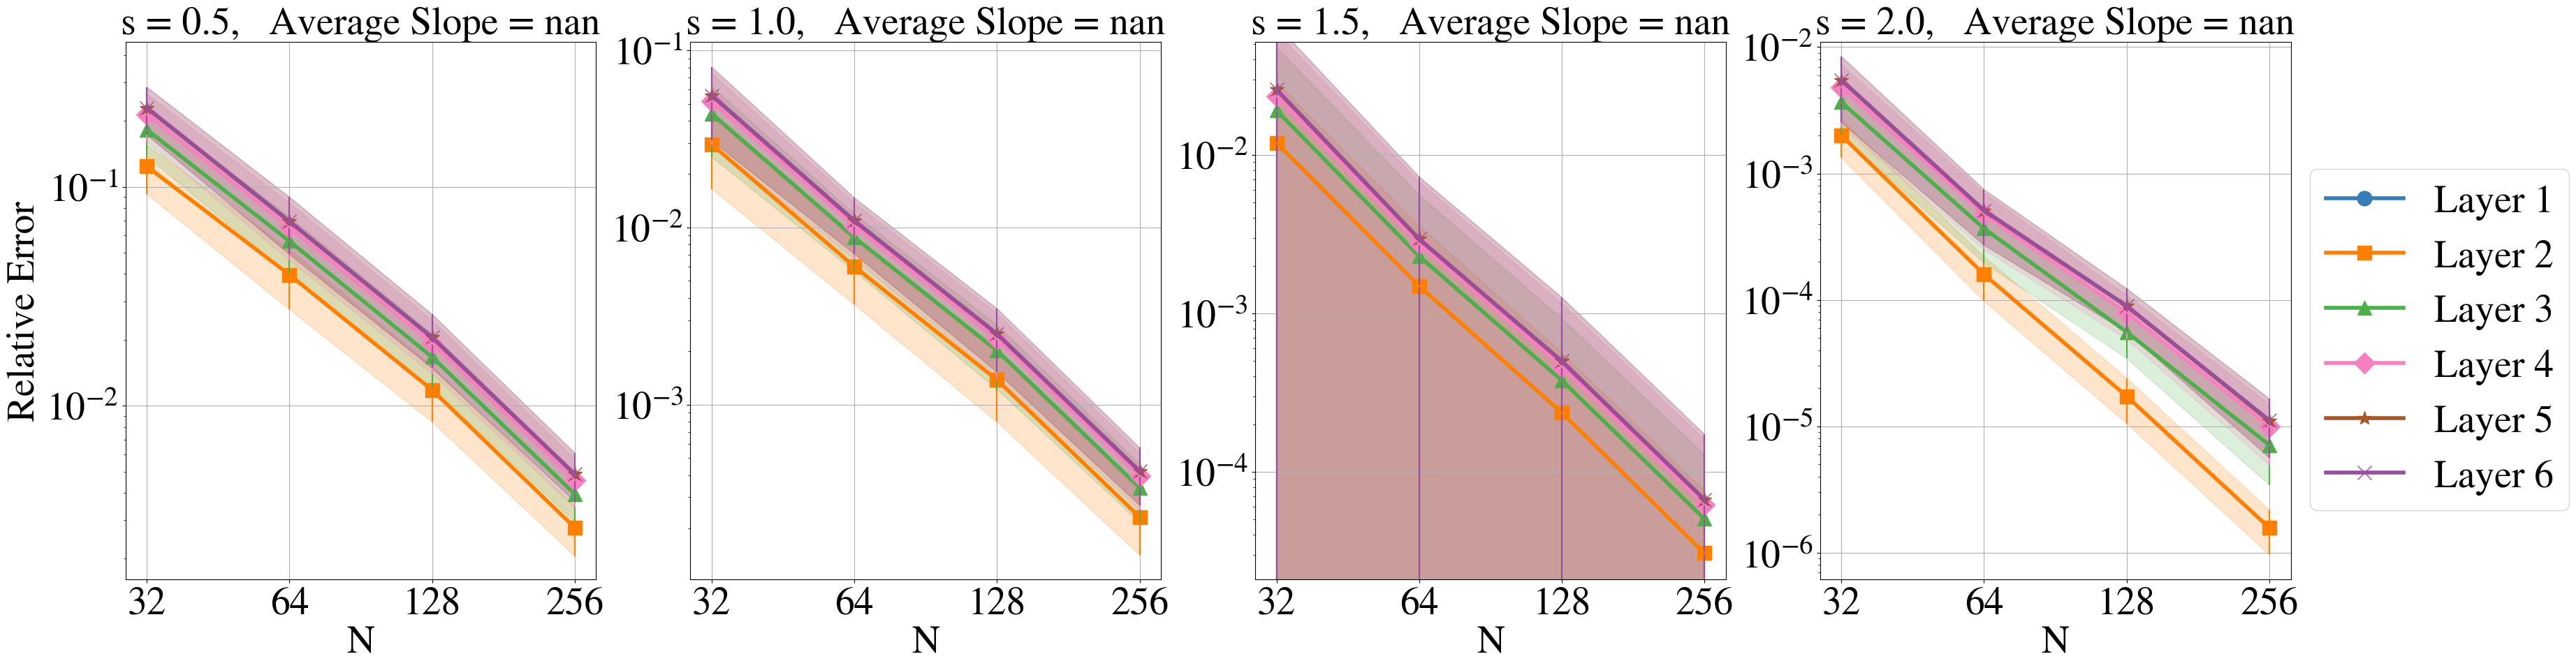

normal_relu


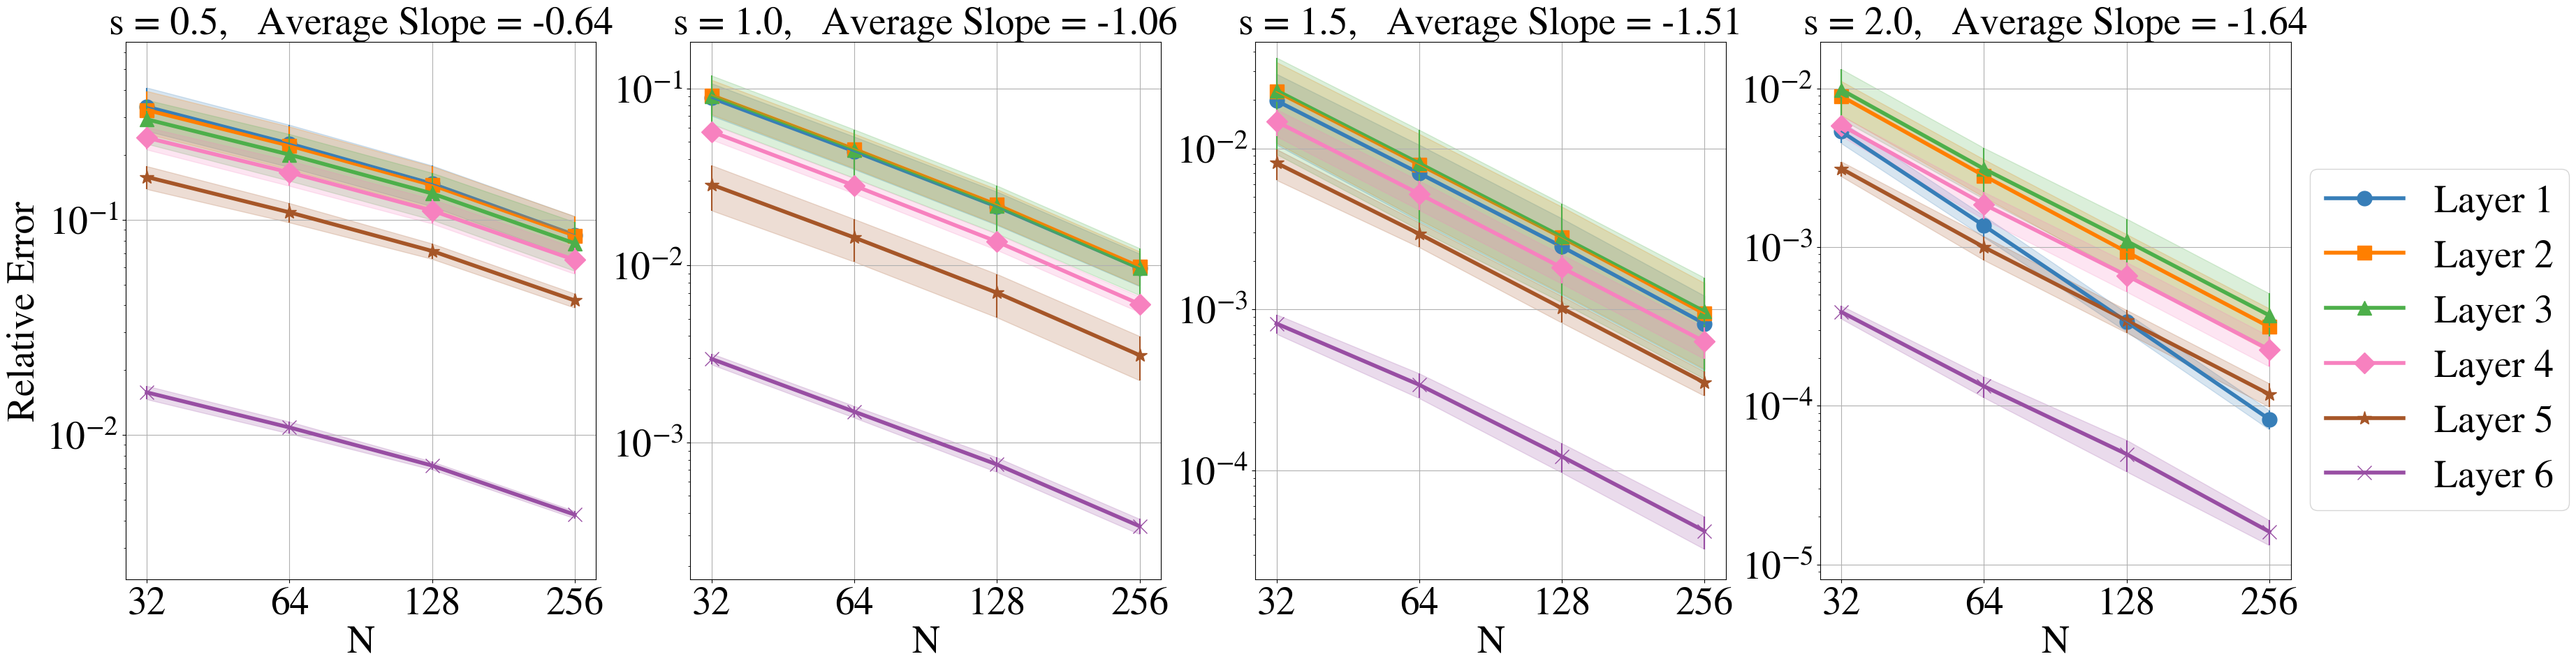

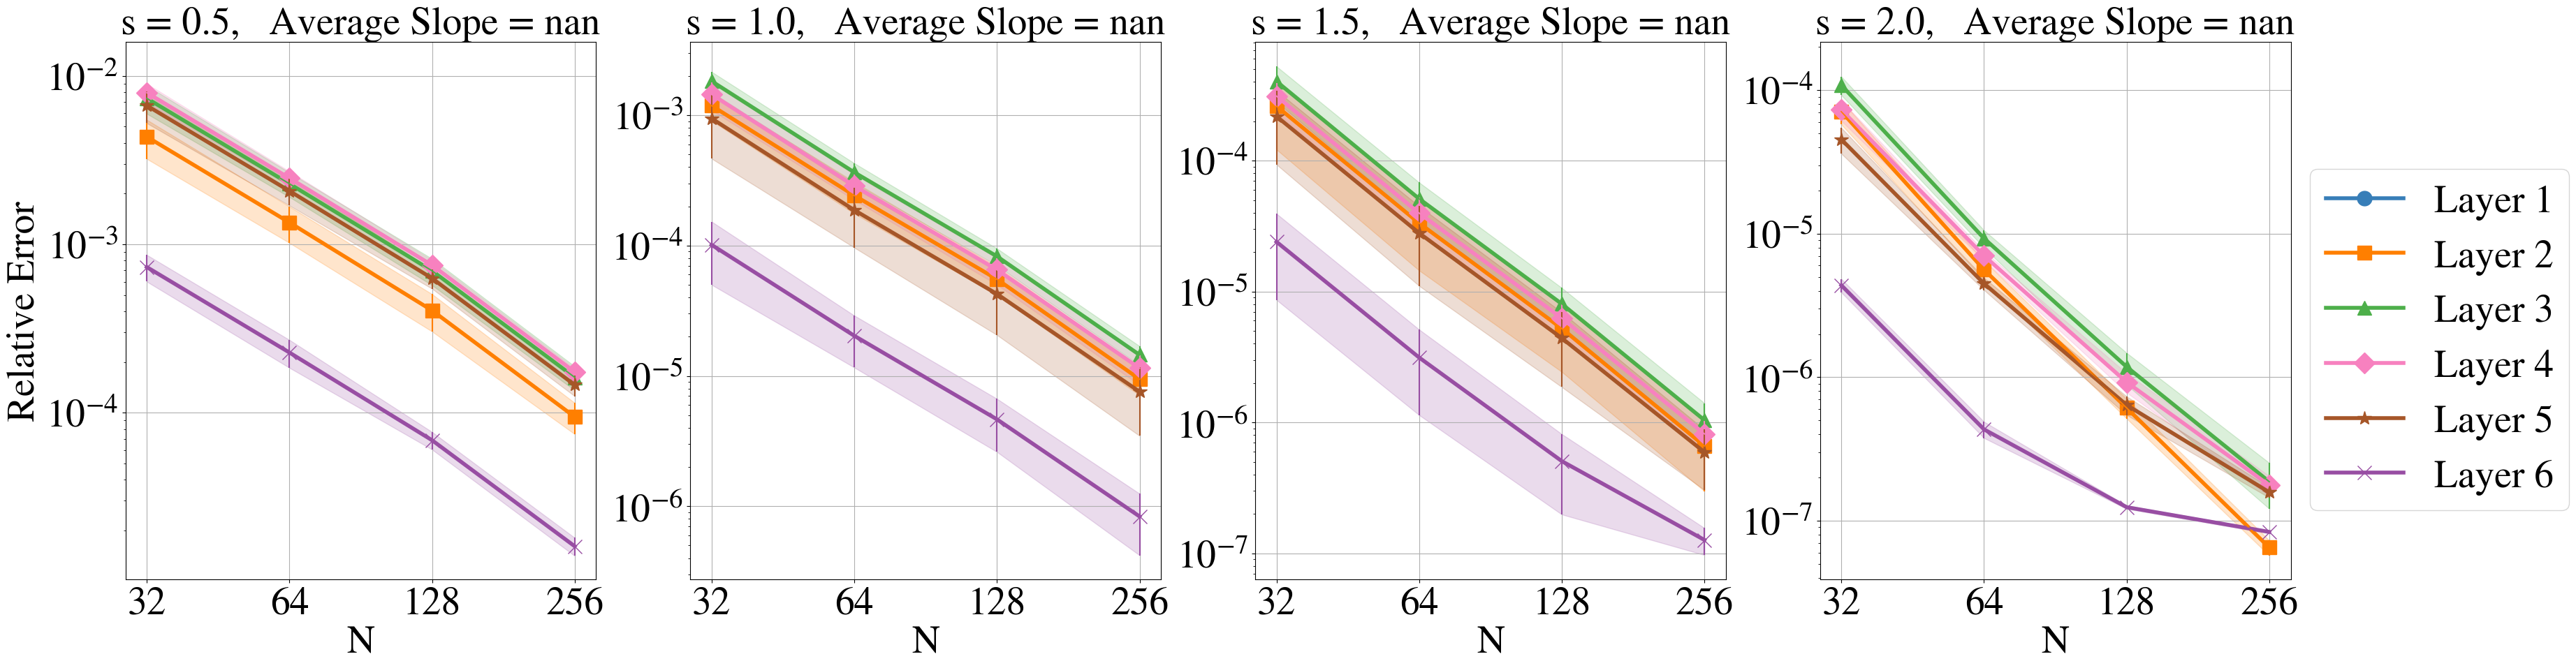

normal_xygrid


In [ ]:
for model_name in models.keys():
    print(model_name)
    outfile = f'err_vs_N_' + model_name + '.png'
    plot_discret_errors_vs_s(models[model_name], grf_data, outfile=outfile)

In [13]:
# discret_errors = {}

# for s in grf_data['s_vals']:
#     x = grf_data[s][512]
#     sizes, norm_ref, errors_upsample, errors_downsample = discretization_errors(models['normal'], x)
#     #
#     discret_errors[s] = (sizes, norm_ref, errors_upsample)
    

In [14]:
# fix, ax = plt.subplots(1,4, figsize=(40, 10))
# for j,s in enumerate(grf_data['s_vals']):
#     title = f's = {s}'
#     plot_discretization_errors(*discret_errors[s],ax=ax[j],title=title)
# # put legend on right of all subplots
# ax[0].set_ylabel('Relative Error')
# ax[-1].legend(bbox_to_anchor=(1, 0.8))
# # save figure
# #plt.savefig('../Figures/Err_vs_N.pdf')
# plt.show()